In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification
import zipfile
zip_ref = zipfile.ZipFile('/content/cards-image-datasetclassification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
 98% 377M/385M [00:04<00:00, 100MB/s] 
100% 385M/385M [00:04<00:00, 95.8MB/s]


In [ ]:
import pandas as pd
df=pd.read_csv('/content/cards.csv')
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [ ]:
len(df['labels'].unique())

53

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_ds=df[df['data set']=='train']
test_ds=df[df['data set']=='test']

valid_ds=df[df['data set']=='valid']

In [ ]:
test_ds.head()

,class index,filepaths,labels,card type,data set
7625,0,test/ace of clubs/1.jpg,ace of clubs,ace,test
7626,0,test/ace of clubs/2.jpg,ace of clubs,ace,test
7627,0,test/ace of clubs/3.jpg,ace of clubs,ace,test
7628,0,test/ace of clubs/4.jpg,ace of clubs,ace,test
7629,0,test/ace of clubs/5.jpg,ace of clubs,ace,test


In [ ]:
valid_ds.head()

,class index,filepaths,labels,card type,data set
7890,0,valid/ace of clubs/1.jpg,ace of clubs,ace,valid
7891,0,valid/ace of clubs/2.jpg,ace of clubs,ace,valid
7892,0,valid/ace of clubs/3.jpg,ace of clubs,ace,valid
7893,0,valid/ace of clubs/4.jpg,ace of clubs,ace,valid
7894,0,valid/ace of clubs/5.jpg,ace of clubs,ace,valid


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True
)
test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [ ]:
batch_size=32
train=train_datagen.flow_from_dataframe(
    train_ds,
    directory="/content/",
    x_col='filepaths',
    y_col='labels',
    class_mode='sparse',
    target_size=(224,224)
)
test=test_datagen.flow_from_dataframe(
    test_ds,
    directory='/content/',
    x_col='filepaths',
    y_col='labels',
    class_mode='sparse',
    target_size=(224,224),
    batch_size=1
)
valid=test_datagen.flow_from_dataframe(
    valid_ds,
    directory='/content/',
    x_col='filepaths',
    y_col='labels',
    class_mode='sparse',
    target_size=(224,224),
    batch_size=1
)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


## Model Building

In [ ]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
conv_base=VGG16(
    input_shape=((224,224,3)),
    include_top=False,
    weights='imagenet'
)
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_base.trainable=True
set_train=False
for layer in conv_base.layers:
  if(layer.name=='block5_conv1'):
    set_train=True
  if(set_train==True):
    layer.trainable=True
  else:
    layer.trainable=False
for layer in conv_base.layers:
  print(layer.name,"   ",layer.trainable)

input_layer     False
block1_conv1     False
block1_conv2     False
block1_pool     False
block2_conv1     False
block2_conv2     False
block2_pool     False
block3_conv1     False
block3_conv2     False
block3_conv3     False
block3_pool     False
block4_conv1     False
block4_conv2     False
block4_conv3     False
block4_pool     False
block5_conv1     True
block5_conv2     True
block5_conv3     True
block5_pool     True


In [ ]:
model=Sequential([
    conv_base,
    Flatten(),
    BatchNormalization(),
    Dense(128,activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(128,activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(53,activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 53)                  │           6,837 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,050,805 (68.86 MB)

 Trainable params: 10,364,853 (39.54 MB)

 Non-trainable params: 7,685,952 (29.32 MB)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
rms=RMSprop(learning_rate=0.0001)
model.compile(
    optimizer=rms,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist=model.fit(train,epochs=30,validation_data=valid,steps_per_epoch=7648//32)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1268 - loss: 3.5859

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 488ms/step - accuracy: 0.1271 - loss: 3.5840 - val_accuracy: 0.3925 - val_loss: 2.0843
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 107s 447ms/step - accuracy: 0.3423 - loss: 2.3831 - val_accuracy: 0.5547 - val_loss: 1.5319
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 108s 453ms/step - accuracy: 0.4489 - loss: 2.0145 - val_accuracy: 0.6264 - val_loss: 1.2572
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 109s 455ms/step - accuracy: 0.5325 - loss: 1.7411 - val_accuracy: 0.6906 - val_loss: 0.9612
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 143s 460ms/step - accuracy: 0.6020 - loss: 1.5181 - val_accuracy: 0.7736 - val_loss: 0.8175
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 108s 453ms/step - accuracy: 0.6438 - loss: 1.3739 - val_accuracy: 0.8000 - val_loss: 0.7824
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 108s 450ms/step - accuracy: 0.6645 - loss: 1.2478 - val_accuracy: 0.7925 - val_loss: 0.7619
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.7025 - loss: 1.13

In [ ]:
len(train)

239

In [ ]:
239*32

7648

In [ ]:
model.save("CardClassification.h5")

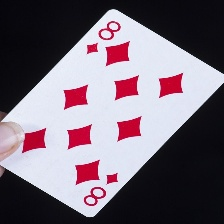

In [ ]:
from PIL import Image
from IPython.display import display
img_path="/content/train/eight of diamonds/001.jpg"
img=Image.open(img_path)
display(img)

In [ ]:
import numpy as np
img=img.resize((224,224))
inp=np.array(img).reshape((1,224,224,3))
ans=model.predict(inp)
val=np.argmax(ans,axis=1)
print(val)
for i,j in train.class_indices.items():
  # print(i,j)
  if(j==val[0]):
    print(i)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[1]
ace of diamonds


In [ ]:
train.class_indices

{'ace of clubs': 0,
 'ace of diamonds': 1,
 'ace of hearts': 2,
 'ace of spades': 3,
 'eight of clubs': 4,
 'eight of diamonds': 5,
 'eight of hearts': 6,
 'eight of spades': 7,
 'five of clubs': 8,
 'five of diamonds': 9,
 'five of hearts': 10,
 'five of spades': 11,
 'four of clubs': 12,
 'four of diamonds': 13,
 'four of hearts': 14,
 'four of spades': 15,
 'jack of clubs': 16,
 'jack of diamonds': 17,
 'jack of hearts': 18,
 'jack of spades': 19,
 'joker': 20,
 'king of clubs': 21,
 'king of diamonds': 22,
 'king of hearts': 23,
 'king of spades': 24,
 'nine of clubs': 25,
 'nine of diamonds': 26,
 'nine of hearts': 27,
 'nine of spades': 28,
 'queen of clubs': 29,
 'queen of diamonds': 30,
 'queen of hearts': 31,
 'queen of spades': 32,
 'seven of clubs': 33,
 'seven of diamonds': 34,
 'seven of hearts': 35,
 'seven of spades': 36,
 'six of clubs': 37,
 'six of diamonds': 38,
 'six of hearts': 39,
 'six of spades': 40,
 'ten of clubs': 41,
 'ten of diamonds': 42,
 'ten of hearts':

[]

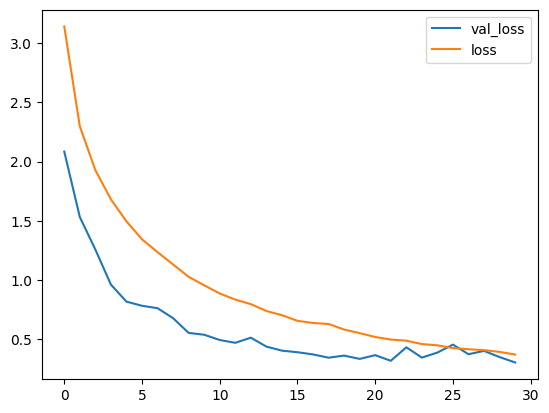

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.plot()

[]

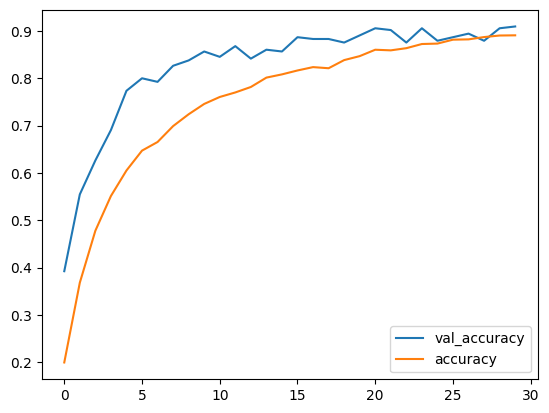

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()
plt.plot()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
accuracy_score(y_pred,)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
